In [1]:
# Display plots in the notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
import numpy as np
import pylab as pl
import pandas as pd
import geopandas as gp
import ast
import json
import urllib
import urllib2
import fiona
from fiona import crs
from cStringIO import StringIO

# Make plots prettyful
pl.style.use('fivethirtyeight')

# Seed random
np.random.seed(123)

In [3]:
# Query Function from Data notebook
SQL_SOURCE = 'https://htv210.cartodb.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [13]:
# Get zipcodes from DB
query = 'select * from nyc_zipcode_highway'# LIMIT 5'
zipcodes_json = json.loads(queryCartoDB(query, format='GeoJSON').read())
zipcodes = gp.GeoDataFrame.from_features(zipcodes_json['features'])
zipcodes.crs = crs.from_epsg(4326)
zipcodes = zipcodes.to_crs(epsg=2263)

In [61]:
zipcodes.columns

Index([u'cartodb_id', u'geometry', u'highway_length', u'zipcode'], dtype='object')

# Task 1

In [27]:
query = '''
SELECT f.*, s.count 
FROM nyc_facilities f
INNER JOIN
    (select facility_id, COUNT(*) as count from nyc_discharge_2013 d
    WHERE 
        lower(d.ccs_diagnosis_description) LIKE '%asthma'
    GROUP BY d.facility_id
    ORDER BY COUNT(*) DESC
    LIMIT 5) s
ON (f.facility_id = s.facility_id)
'''
res = json.loads(queryCartoDB(query, format='GeoJSON').read())
top_facilities = gp.GeoDataFrame.from_features(res['features'])

# Convert to 2263
top_facilities.crs = crs.from_epsg(4326)
top_facilities = top_facilities.to_crs(epsg=2263)

# Create circles for plotting
top_facilities['geometry'] = top_facilities.geometry.buffer(3000)

In [58]:
# Top 5 facilities in order
top_facilities.sort('count',ascending=False)[['facility_name', 'count']]

,facility_name,count
2,Lincoln Medical & Mental Health Center,1878
1,Montefiore Medical Center - Henry & Lucy Moses...,1786
4,Kings County Hospital Center,1057
0,Jacobi Medical Center,920
3,Bronx-Lebanon Hospital Center - Concourse Divi...,890


(900000.0, 1080000.0, 120000.0, 280000.0)

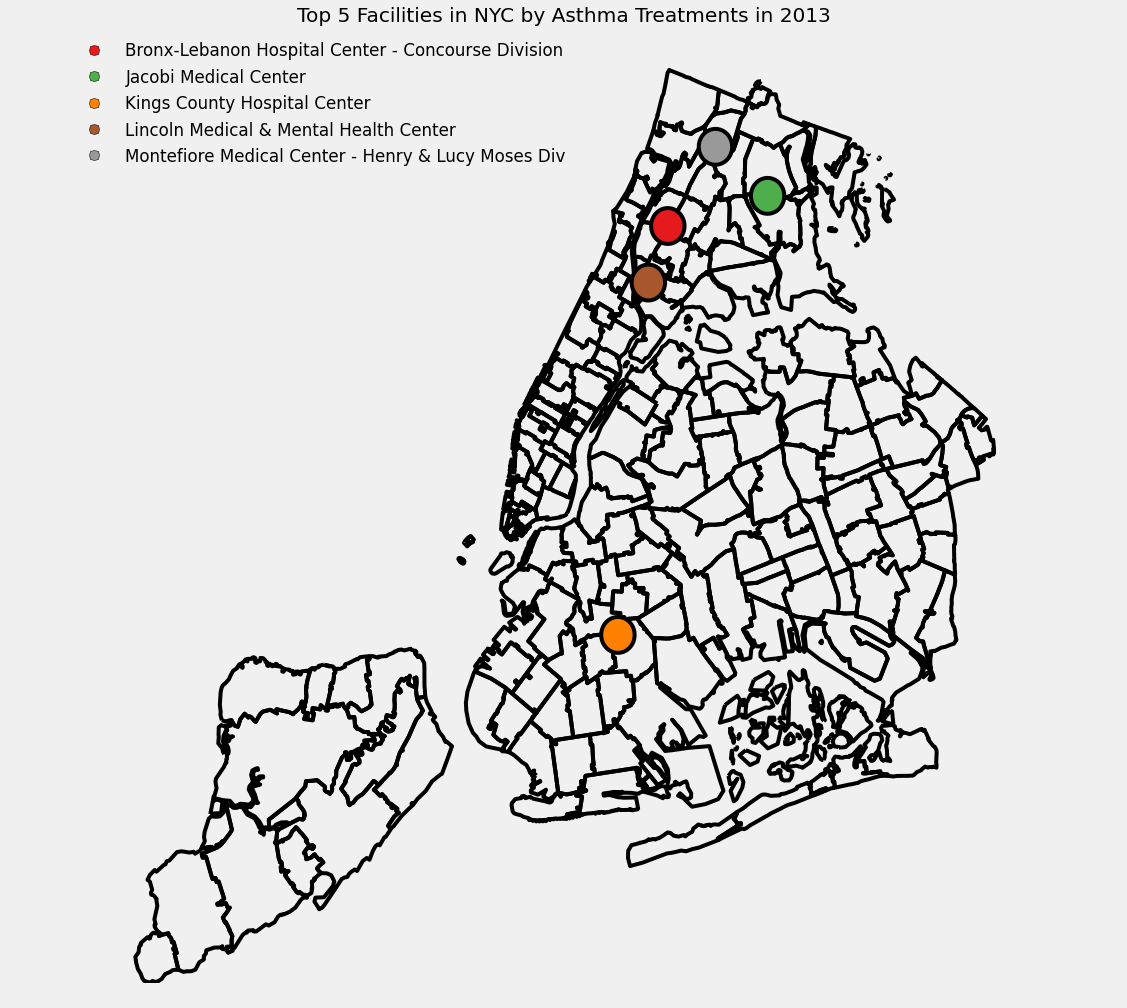

In [60]:
# Plot
figure, ax = pl.subplots(figsize=(16,16))

# Plot on separate axes.  For some reason I couldn't get the circles to show up
# above the zip codes any other way.
ax2 = ax.twinx()

# Plot
top_facilities.plot(axes=ax2, column='facility_name', categorical=True, legend=True, alpha=1)
zipcodes.plot(axes=ax, alpha=0)

# Fix scale
ax2.set_ylim(ax.get_ylim())

# Title and remove grid lines
ax.set_title('Top 5 Facilities in NYC by Asthma Treatments in 2013')
ax.axis('off')
ax2.axis('off')

# Task 2

In [66]:
query = '''
SELECT f.*, z.zipcode, z.highway_length, s.count 
FROM nyc_facilities f
INNER JOIN
    (select facility_id, COUNT(*) as count from nyc_discharge_2013 d
    WHERE 
        lower(d.ccs_diagnosis_description) LIKE '%asthma'
    GROUP BY d.facility_id
    ORDER BY COUNT(*) DESC
    LIMIT 5) s
ON (f.facility_id = s.facility_id)
INNER JOIN
    nyc_zipcode_highway z
ON ST_CONTAINS(z.the_geom, f.the_geom)
'''
res = json.loads(queryCartoDB(query, format='GeoJSON').read())
top_facilities = gp.GeoDataFrame.from_features(res['features'])

# Convert to 2263
top_facilities.crs = crs.from_epsg(4326)
top_facilities = top_facilities.to_crs(epsg=2263)

# Create circles for plotting
top_facilities['geometry'] = top_facilities.geometry.buffer(3000)

In [68]:
# Top 5 facilities in order
top_facilities.sort('count',ascending=False)[['facility_name', 'count', 'zipcode', 'highway_length']]

,facility_name,count,zipcode,highway_length
2,Lincoln Medical & Mental Health Center,1878,10451,7.914185
1,Montefiore Medical Center - Henry & Lucy Moses...,1786,10467,19.172015
4,Kings County Hospital Center,1057,11203,2.212840
0,Jacobi Medical Center,920,10461,18.102258
3,Bronx-Lebanon Hospital Center - Concourse Divi...,890,10457,5.017199


(900000.0, 1080000.0, 120000.0, 280000.0)

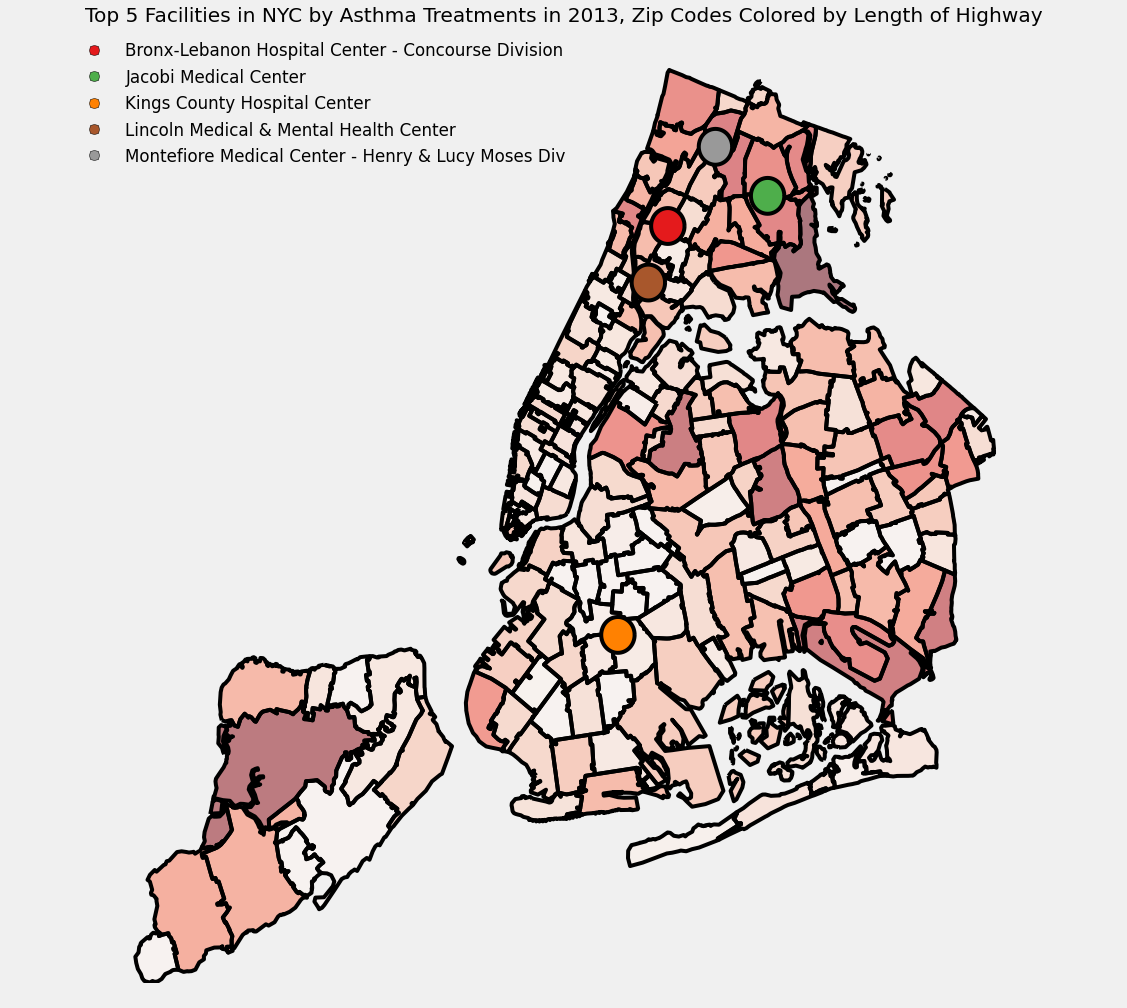

In [69]:
# Plot
figure, ax = pl.subplots(figsize=(16,16))

# Plot on separate axes.  For some reason I couldn't get the circles to show up
# above the zip codes any other way.
ax2 = ax.twinx()

# Plot
top_facilities.plot(axes=ax2, column='facility_name', categorical=True, legend=True, alpha=1)
zipcodes.plot(axes=ax, column='highway_length',colormap='Reds')

# Fix scale
ax2.set_ylim(ax.get_ylim())

# Title and remove grid lines
ax.set_title('Top 5 Facilities in NYC by Asthma Treatments in 2013, Zip Codes Colored by Length of Highway')
ax.axis('off')
ax2.axis('off')

In [22]:
query = 'select * from nyc_facilities LIMIT 5'
res = json.loads(queryCartoDB(query, format='GeoJSON').read())
facilities = gp.GeoDataFrame.from_features(res['features'])